# Part 2

### III.1. Spatial interaction models: 8 Briefly introduce the spatial interaction models covered in the lectures using equations and defining the terms, taking particular care in explaining the role of the parameters.



The family of spatial interaction models can be regarded as an extension of the most commonly used basic gravity model (Wilson, 1971). It predicts the movement or flows between origins and destinations by examining the distance (or cost) between them (GHCM). Our lecture covers the family of spatial interaction models containing four subtypes: Unconstrained Model, Origin Constrained Model, The Destination Constrained Model, and the Doubly Constrained Model (Batty, 2022). The Unconstrained Model is the most basic one and can be used when the only known is the total population and flows. Both Origin Constrained Model and Destination Constrained Model belong to the singly constrained model that the total number of population and flows either leaving the origin or accessing the destination is fixed. While in the Doubly Constrained Model, both the population and flows leaving the origin and accessing the destination are fixed. The equations and parameters are listed as follows:

### III.2. Using the information of population, jobs and flows, select a spatial interaction model and calibrate the parameter beta. Make sure to justify your selection of model.

In [156]:
#import the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf
import seaborn as sns

In [157]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [485]:
#read in data
cdatasub = pd.read_csv("london_flows.csv")

In [486]:
cdatasub.head(5)

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [487]:
#show the actual flows between boroughs
cdatasubmat = pd.pivot_table(cdatasub, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
#show the data
cdatasubmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


<AxesSubplot:xlabel='distance', ylabel='flows'>

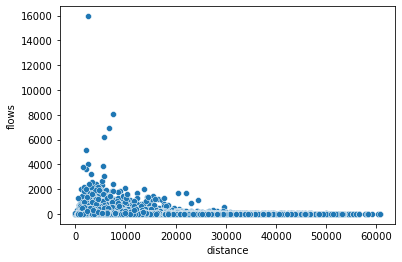

In [488]:
#check data distribution 
#plot the distance and flow
sns.scatterplot(data=cdatasub, x="distance", y="flows")
#poission distribution!

In [489]:
#so to run a poission regression, we need to adjust our variables
import statsmodels.api as sm
import statsmodels.formula.api as smf

#take the variables and produce logarithms of them
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    cdatasub[f"log_{x}"] = np.log(cdatasub[x]+0.0000000001)
    log_x_vars.append(f"log_{x}")

### Unconstrained model

In [214]:
#create the formula
formula = 'flows ~ log_population + log_jobs + log_distance'

#run the regression
uncosim = smf.glm(formula = formula, 
                  data=cdatasub, 
                  family=sm.families.Poisson()).fit()


In [215]:
#extract the summary of the constrained model
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    61470
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4687e+06
Date:                Mon, 09 May 2022   Deviance:                   2.7651e+06
Time:                        23:15:31   Pearson chi2:                 7.05e+06
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -10.5246      0.010  -1084.

In [216]:
#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
cdatasub["unconstrainedEst"] = predictions_summary_frame["mean"]

In [217]:
cdatasub

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,unconstrainedEst
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,45.840497
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,0.592568
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,0.863540
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,36.646435
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,12.346951
...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,26.540716
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,40.963552
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,4.533971
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,9.111164


In [218]:
#turn it into a little matrix and have a look at your handy work
cdatasubmat1 = cdatasub.pivot_table(values ="unconstrainedEst", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.083162,1.847050e+02
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.613971,NaN,NaN,3.402272e+02
Acton Town,NaN,NaN,NaN,28.911588,29.361127,NaN,4.229660,1.594061,NaN,29.998990,...,24.276710,3.374436,9.684641,7.895015,NaN,3.760860,NaN,3.965421,NaN,4.694908e+03
Aldgate,NaN,NaN,8.087940,NaN,26.269417,NaN,NaN,1.276157,NaN,25.761247,...,19.429431,NaN,8.012124,6.194873,NaN,3.123145,NaN,3.254546,NaN,3.979789e+03
Aldgate East,NaN,NaN,8.737306,27.944049,NaN,NaN,3.466572,1.379123,NaN,27.768720,...,20.990766,2.915028,8.653632,6.690784,NaN,3.389314,NaN,3.515881,NaN,4.362182e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,12.122827,35.986771,36.713319,NaN,NaN,NaN,NaN,37.027364,...,29.186876,NaN,12.035605,NaN,NaN,NaN,NaN,NaN,NaN,5.679485e+03
Woodgrange Park,NaN,0.796113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.271242e+01
Woodside Park,NaN,NaN,8.410003,24.673530,25.057413,NaN,3.347816,NaN,NaN,25.727392,...,20.236871,NaN,8.295013,NaN,NaN,NaN,NaN,NaN,NaN,3.785712e+03


In [219]:
CalcRSqaured(cdatasub["flows"], cdatasub["unconstrainedEst"])

0.2869332262041552

In [220]:
CalcRMSE(cdatasub["flows"], cdatasub["unconstrainedEst"])

111.124

## IV. Scenarios
### IV.1. Scenario A: assume that Canary Wharf has a 50% decrease in jobs after Brexit. Using the calibrated parameter beta, compute the new flows for scenario A. Make sure the number of commuters is conserved.

* it is an origin-constrained model 


In [221]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + log_jobs + log_distance-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    61073
Model Family:                 Poisson   Df Model:                          400
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2652e+06
Date:                Mon, 09 May 2022   Deviance:                   2.3581e+06
Time:                        23:16:39   Pearson chi2:                 4.87e+06
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [222]:
cdatasub["prodsimfitted"] = np.round(prodSim.mu)
#here's the matrix
cdatasubmat2 = cdatasub.pivot_table(values ="prodsimfitted", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
cdatasubmat2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1228.0
Acton Town,NaN,NaN,NaN,23.0,23.0,NaN,3.0,1.0,NaN,24.0,...,19.0,3.0,8.0,6.0,NaN,3.0,NaN,3.0,NaN,3742.0
Aldgate,NaN,NaN,6.0,NaN,19.0,NaN,NaN,1.0,NaN,19.0,...,14.0,NaN,6.0,5.0,NaN,2.0,NaN,2.0,NaN,2888.0
Aldgate East,NaN,NaN,6.0,20.0,NaN,NaN,3.0,1.0,NaN,20.0,...,15.0,2.0,6.0,5.0,NaN,3.0,NaN,3.0,NaN,3173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,11.0,31.0,32.0,NaN,NaN,NaN,NaN,32.0,...,25.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.0
Woodside Park,NaN,NaN,7.0,20.0,21.0,NaN,3.0,NaN,NaN,21.0,...,17.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3096.0


In [223]:
cdatasubmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [224]:
CalcRSqaured(cdatasub["flows"], cdatasub["prodsimfitted"])

0.3580053002526627

In [225]:
CalcRMSE(cdatasub["flows"], cdatasub["prodsimfitted"])

105.376

In [226]:
prodSim.params[-1]

-0.03803828056550343

In [227]:
#We can do this by pulling out the parameter values - refresh parameters 
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
cdatasub = cdatasub.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
cdatasub.drop(columns = ["coef"], inplace = True)
#check this has worked
cdatasub.head()

/tmp/ipykernel_302/2719768554.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,unconstrainedEst,prodsimfitted,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,45.840497,148.0,-4.035699
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,0.592568,2.0,-4.035699
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,0.863540,3.0,-4.035699
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,36.646435,118.0,-4.035699
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,12.346951,40.0,-4.035699


In [245]:
alpha_i = prodSim.params[0:399]
gamma = prodSim.params[-2]
beta = prodSim.params[-1] 
print(gamma)
print(beta)

0.83158685122439
-0.04162501598374163


#### Canary Wharf 50% decrese in jobs

In [559]:
cdatasub[cdatasub['station_destination'] =='Canary Wharf']

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsimfitted2,...,Ai_new,Bj_new,SIM_est_pow,SIM_est_pow_old,SIM_est_pow_h,SIM_est_pow_hundred,SIM_est_pow_t,SIM_est_pow_tenth,change_T,change_H
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,92.0,...,2.573147e-19,0.946423,93.0,93.0,87.0,87.0,14.0,14.0,13.0,86.0
126,Acton Town,Canary Wharf,57,3745,58772,20398.165882,8.228177,10.981421,9.923200,139.0,...,5.231171e-21,0.946423,144.0,144.0,156.0,156.0,172.0,172.0,115.0,99.0
348,Aldgate,Canary Wharf,1,2886,58772,6564.419680,7.967627,10.981421,8.789419,107.0,...,9.052758e-20,0.946423,110.0,110.0,113.0,113.0,55.0,55.0,54.0,112.0
595,Aldgate East,Canary Wharf,3,3172,58772,5127.998899,8.062118,10.981421,8.542471,118.0,...,8.324650e-20,0.946423,118.0,118.0,112.0,112.0,25.0,25.0,22.0,109.0
817,All Saints,Canary Wharf,67,740,58772,1340.088733,6.606650,10.981421,7.200491,105.0,...,8.401739e-19,0.946423,99.0,99.0,70.0,70.0,1.0,1.0,-66.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60595,Wood Green,Canary Wharf,64,6667,58772,16849.246595,8.804925,10.981421,9.732061,246.0,...,8.750978e-21,0.946423,252.0,252.0,264.0,264.0,274.0,274.0,210.0,200.0
60838,Wood Lane,Canary Wharf,0,1088,58772,17092.091760,6.992096,10.981421,9.746371,45.0,...,1.672009e-20,0.946423,47.0,47.0,53.0,53.0,89.0,89.0,89.0,53.0
61062,Woodford,Canary Wharf,192,4868,58772,13963.787075,8.490438,10.981421,9.544223,188.0,...,2.089395e-21,0.946423,185.0,185.0,164.0,164.0,26.0,26.0,-166.0,-28.0
61294,Woodside Park,Canary Wharf,42,3093,58772,22356.567178,8.036897,10.981421,10.014875,121.0,...,3.519245e-21,0.946423,124.0,124.0,129.0,129.0,130.0,130.0,88.0,87.0


In [560]:
# Canary Wharf 50% decrese in jobs
def new_job(row):
    if row["station_destination"] == "Canary Wharf":
        val = 58772/2
    else:
        val = row["jobs"]
    return val
        
cdatasub["jobs_new"] = cdatasub.apply(new_job, axis =1)
cdatasub.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsimfitted2,...,Bj_new,SIM_est_pow,SIM_est_pow_old,SIM_est_pow_h,SIM_est_pow_hundred,SIM_est_pow_t,SIM_est_pow_tenth,change_T,change_H,jobs_new
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,125.0,...,2.934745,129.0,129.0,151.0,151.0,272.0,272.0,272.0,151.0,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.0,...,1.891667,3.0,3.0,3.0,3.0,1.0,1.0,0.0,2.0,442.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,5.0,...,49.650579,5.0,5.0,5.0,5.0,3.0,3.0,0.0,2.0,665.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,92.0,...,0.946423,93.0,93.0,87.0,87.0,14.0,14.0,13.0,86.0,29386.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,26.0,...,0.546894,24.0,24.0,17.0,17.0,0.0,0.0,-37.0,-20.0,15428.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,8.0,...,24.186013,8.0,8.0,10.0,10.0,18.0,18.0,17.0,9.0,1208.0
6,Abbey Road,Custom House,0,599,845,3824.855630,6.395262,6.739337,8.249276,6.0,...,10.861529,6.0,6.0,5.0,5.0,1.0,1.0,1.0,5.0,845.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,13.0,...,11.056759,13.0,13.0,16.0,16.0,26.0,26.0,24.0,14.0,1748.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,6.0,...,3.630029,6.0,6.0,6.0,6.0,2.0,2.0,-5.0,-1.0,850.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,4.0,...,20.866805,4.0,4.0,4.0,4.0,1.0,1.0,0.0,3.0,611.0


In [561]:
# we found the total flows has changed
cdatasub["prodsimest2"] = np.exp(cdatasub["alpha_i"] +
                                           gamma*np.log(cdatasub["jobs_new"]) - 
                                           beta*cdatasub["log_distance"])

cdatasub["prodsimest2"] = round(cdatasub["prodsimest2"],0)
#now we can convert the pivot table into a matrix
cdatasubmat3 = cdatasub.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat3

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5167.0,197498.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1127.0,NaN,NaN,579688.0
Acton Town,NaN,NaN,NaN,13359.0,13580.0,NaN,1815.0,802.0,NaN,13783.0,...,11171.0,1567.0,4623.0,3431.0,NaN,1853.0,NaN,1926.0,NaN,2100182.0
Aldgate,NaN,NaN,3470.0,NaN,9286.0,NaN,NaN,599.0,NaN,9736.0,...,8344.0,NaN,3364.0,2603.0,NaN,1344.0,NaN,1410.0,NaN,1530205.0
Aldgate East,NaN,NaN,3770.0,9927.0,NaN,NaN,1537.0,650.0,NaN,10598.0,...,9066.0,1273.0,3656.0,2829.0,NaN,1455.0,NaN,1532.0,NaN,1689075.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,6353.0,17744.0,17971.0,NaN,NaN,NaN,NaN,18429.0,...,15251.0,NaN,6148.0,NaN,NaN,NaN,NaN,NaN,NaN,2786747.0
Woodgrange Park,NaN,3213.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201641.0
Woodside Park,NaN,NaN,4123.0,11623.0,11815.0,NaN,1676.0,NaN,NaN,11945.0,...,9902.0,NaN,4011.0,NaN,NaN,NaN,NaN,NaN,NaN,1751621.0


In [562]:
# to conserve the commuters, we calculate A_i 
Dj2_gamma = cdatasub["jobs"]**gamma
dist_beta = cdatasub["distance"]**-beta #why -?


cdatasub["Ai1"] = Dj2_gamma * dist_beta


A_i = pd.DataFrame(cdatasub.groupby(["station_origin"])["Ai1"].agg(np.sum))


A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)


cdatasub = cdatasub.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [563]:
cdatasub 

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsimfitted2,...,SIM_est_pow_h,SIM_est_pow_hundred,SIM_est_pow_t,SIM_est_pow_tenth,change_T,change_H,jobs_new,prodsimest2,Ai1,A_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,125.0,...,151.0,151.0,272.0,272.0,272.0,151.0,78549.0,56234.0,15833.177635,0.000016
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.0,...,3.0,3.0,1.0,1.0,0.0,2.0,442.0,758.0,213.492702,0.000016
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,5.0,...,5.0,5.0,3.0,3.0,0.0,2.0,665.0,1037.0,291.928407,0.000016
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,92.0,...,87.0,87.0,14.0,14.0,13.0,86.0,29386.0,24446.0,12248.972478,0.000016
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,26.0,...,17.0,17.0,0.0,0.0,-37.0,-20.0,15428.0,13922.0,3919.739642,0.000016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,288.0,...,300.0,300.0,385.0,385.0,258.0,173.0,3342.0,53695.0,1165.468074,0.000015
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,116.0,...,93.0,93.0,7.0,7.0,-601.0,-515.0,5487.0,79949.0,1735.340069,0.000015
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,35.0,...,40.0,40.0,74.0,74.0,68.0,34.0,400.0,9086.0,197.221049,0.000015
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,82.0,...,65.0,65.0,5.0,5.0,-76.0,-16.0,893.0,17385.0,377.351587,0.000015


In [565]:
#now the flow is controlled 
#to check everything works, recreate the original estimates
cdatasub["prodsimest3"] = cdatasub["A_i"]*cdatasub["population"]*Dj2_gamma*dist_beta
#round
cdatasub["prodsimest3"] = round(cdatasub["prodsimest3"])
#check
# cdatasub[["prodsimfitted", "prodsimest3"]]

In [566]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = cdatasub["jobs_new"]**gamma

#calcualte the first stage of the Ai values
cdatasub["Ai1"] = Dj3_gamma * dist_beta

#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["station_origin"])["Ai1"].agg(np.sum))

#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)

#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [567]:
#to check everything works, recreate the original estimates
cdatasub["prodsimest4"] = cdatasub["A_i2"]*cdatasub["population"]*Dj3_gamma*dist_beta
#round
cdatasub["prodsimest4"] = round(cdatasub["prodsimest4"])

In [568]:
#now, the flow is conserved
cdatasubmat4 = cdatasub.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat4

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,598.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1228.0
Acton Town,NaN,NaN,NaN,24.0,24.0,NaN,3.0,1.0,NaN,25.0,...,20.0,3.0,8.0,6.0,NaN,3.0,NaN,3.0,NaN,3748.0
Aldgate,NaN,NaN,7.0,NaN,18.0,NaN,NaN,1.0,NaN,18.0,...,16.0,NaN,6.0,5.0,NaN,3.0,NaN,3.0,NaN,2888.0
Aldgate East,NaN,NaN,7.0,19.0,NaN,NaN,3.0,1.0,NaN,20.0,...,17.0,2.0,7.0,5.0,NaN,3.0,NaN,3.0,NaN,3175.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,11.0,31.0,31.0,NaN,NaN,NaN,NaN,32.0,...,27.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4865.0
Woodgrange Park,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,528.0
Woodside Park,NaN,NaN,7.0,21.0,21.0,NaN,3.0,NaN,NaN,21.0,...,17.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [569]:
cdatasubmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [570]:
CalcRSqaured(cdatasub["flows"], cdatasub["prodsimest4"])

0.3678850038255601

In [571]:
CalcRMSE(cdatasub["flows"], cdatasub["prodsimest4"])

104.89

#### showing the changing 

In [572]:
cdatasub['change_A'] = cdatasub['prodsimest4']-cdatasub['flows']

In [573]:
cdatasub['change_A']

0        171.0
1          1.0
2          0.0
3         73.0
4          5.0
         ...  
61469     28.0
61470   -378.0
61471     20.0
61472    -31.0
61473     -8.0
Name: change_A, Length: 61474, dtype: float64

In [574]:
cdatasub.sort_values(by=['change_A'])

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsimfitted2,...,change_T,change_H,jobs_new,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,change_A
55949,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,11.117985,11.271478,7.841082,3360.0,...,-15498.0,-12949.0,78549.0,1403491.0,15238.235697,0.000003,2742.0,0.000003,2782.0,-13164.0
55974,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,11.117985,10.981421,8.913817,2357.0,...,-4378.0,-5207.0,29386.0,641907.0,6969.425800,0.000003,2232.0,0.000003,1272.0,-6813.0
32654,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,10.391976,10.981421,8.644567,1140.0,...,-5618.0,-4906.0,29386.0,305102.0,6907.871172,0.000003,1072.0,0.000003,611.0,-5554.0
50095,Stratford,Liverpool Street,6946,59311,61122,6698.461270,10.990550,11.020627,8.809633,1394.0,...,-6692.0,-5687.0,61122.0,857694.0,12770.217256,0.000002,1772.0,0.000002,1794.0,-5152.0
54825,Victoria,Oxford Circus,5181,37517,44368,2220.166284,10.532549,10.700274,7.705337,1233.0,...,-5073.0,-4131.0,44368.0,478972.0,9434.086664,0.000003,946.0,0.000003,960.0,-4221.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56175,Waterloo,Victoria,285,67372,33251,2188.414963,11.117985,10.411840,7.690933,1599.0,...,-126.0,1168.0,33251.0,683282.0,7418.650273,0.000003,1335.0,0.000003,1354.0,1069.0
49911,Stratford,Bank and Monument,1138,59311,78549,7539.963954,10.990550,11.271478,8.927973,2364.0,...,-222.0,1098.0,78549.0,1060770.0,15793.823857,0.000002,2191.0,0.000002,2219.0,1081.0
54669,Victoria,Bank and Monument,480,37517,78549,4731.369406,10.532549,11.271478,8.461970,1814.0,...,835.0,1498.0,78549.0,789641.0,15553.177773,0.000003,1559.0,0.000003,1582.0,1102.0
11664,Clapham Junction,Stratford,16,6931,55954,19901.683901,8.843759,10.932285,9.898560,692.0,...,768.0,737.0,55954.0,541106.0,12299.147491,0.000014,1230.0,0.000014,1230.0,1214.0


In [575]:
cdatasub.sort_values('change_A').head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsimfitted2,...,change_T,change_H,jobs_new,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,change_A
55949,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,11.117985,11.271478,7.841082,3360.0,...,-15498.0,-12949.0,78549.0,1403491.0,15238.235697,0.000003,2742.0,0.000003,2782.0,-13164.0
55974,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,11.117985,10.981421,8.913817,2357.0,...,-4378.0,-5207.0,29386.0,641907.0,6969.425800,0.000003,2232.0,0.000003,1272.0,-6813.0
32654,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,10.391976,10.981421,8.644567,1140.0,...,-5618.0,-4906.0,29386.0,305102.0,6907.871172,0.000003,1072.0,0.000003,611.0,-5554.0
50095,Stratford,Liverpool Street,6946,59311,61122,6698.461270,10.990550,11.020627,8.809633,1394.0,...,-6692.0,-5687.0,61122.0,857694.0,12770.217256,0.000002,1772.0,0.000002,1794.0,-5152.0
54825,Victoria,Oxford Circus,5181,37517,44368,2220.166284,10.532549,10.700274,7.705337,1233.0,...,-5073.0,-4131.0,44368.0,478972.0,9434.086664,0.000003,946.0,0.000003,960.0,-4221.0
8542,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,10.204555,10.981421,7.863984,935.0,...,-4020.0,-3401.0,29386.0,237543.0,6732.473661,0.000002,809.0,0.000003,461.0,-3569.0
18965,Finsbury Park,Highbury & Islington,3659,24735,25385,2057.343960,10.115975,10.141914,7.629171,368.0,...,-3657.0,-3440.0,25385.0,208473.0,5915.020448,0.000003,380.0,0.000003,385.0,-3274.0
32403,Liverpool Street,Farringdon,3755,31473,25592,1602.285759,10.356885,10.150035,7.379186,569.0,...,-3746.0,-3332.0,25592.0,235996.0,5906.255249,0.000003,490.0,0.000003,497.0,-3258.0
49948,Stratford,Canary Wharf,3875,59311,58772,5482.674320,10.990550,10.981421,8.609348,1736.0,...,-3798.0,-2517.0,29386.0,463419.0,6899.859866,0.000002,1704.0,0.000002,969.0,-2906.0
8662,Canada Water,London Bridge,3202,27026,29930,3077.343459,10.204555,10.306617,8.031822,547.0,...,-3162.0,-2743.0,29930.0,242531.0,6873.863745,0.000002,464.0,0.000003,470.0,-2732.0


In [279]:
cdatasub.sort_values('prodsimest4').tail(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,unconstrainedEst,...,alpha_i,jobs_new,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,change_A,doubsimfitted2
43533,Romford,Stratford,2031,4423,55954,13743.387084,8.394573,10.932285,9.528313,175.082255,...,-1.205151,55954.0,3822.0,12753.809295,0.000033,1839.0,0.000033,1839.0,-192.0,1493.0
43528,Romford,Liverpool Street,1714,4423,61122,20441.848354,8.394573,11.020627,9.925339,185.463000,...,-1.205151,61122.0,4176.0,13934.895965,0.000033,2009.0,0.000033,2009.0,295.0,1877.0
31703,Lewisham,Bank and Monument,585,7868,78549,11514.359702,8.970559,11.271478,9.351350,376.751773,...,-1.480857,78549.0,3820.0,16796.437830,0.000014,1914.0,0.000016,2085.0,1500.0,1526.0
61437,Woolwich Arsenal,Bank and Monument,1340,7892,78549,14441.593526,8.973605,11.271478,9.577868,374.153461,...,-1.450833,78549.0,3971.0,16941.786910,0.000015,1962.0,0.000016,2143.0,803.0,1587.0
56154,Waterloo,Stratford,1268,67372,55954,10082.918398,11.117985,10.932285,9.218598,1670.745545,...,-1.159703,55954.0,3952.0,12604.437925,0.000003,2171.0,0.000003,2203.0,935.0,1480.0
27864,Ilford,Stratford,3080,5298,55954,5635.299025,8.575085,10.932285,8.636805,210.824430,...,-1.036178,55954.0,4374.0,12328.560722,0.000034,2204.0,0.000034,2204.0,-876.0,1840.0
49911,Stratford,Bank and Monument,1138,59311,78549,7539.963954,10.990550,11.271478,8.927973,2023.900950,...,-1.317128,78549.0,4428.0,16528.105193,0.000002,2187.0,0.000002,2215.0,1077.0,2364.0
56074,Waterloo,Liverpool Street,1571,67372,61122,3384.457128,11.117985,11.020627,8.126949,1882.942323,...,-1.159703,61122.0,4081.0,13013.515955,0.000003,2242.0,0.000003,2275.0,704.0,1955.0
27858,Ilford,Liverpool Street,1684,5298,61122,12333.760295,8.575085,11.020627,9.420096,219.762404,...,-1.036178,61122.0,4850.0,13669.643674,0.000034,2444.0,0.000034,2444.0,760.0,2285.0
55949,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,11.117985,11.271478,7.841082,2351.887237,...,-1.159703,78549.0,4973.0,15858.709086,0.000003,2732.0,0.000003,2772.0,-13174.0,3360.0


In [282]:
cdatasub.sort_values('flows').tail(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,unconstrainedEst,...,alpha_i,jobs_new,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,change_A,doubsimfitted2
8662,Canada Water,London Bridge,3202,27026,29930,3077.343459,10.204555,10.306617,8.031822,489.400360,...,-2.058346,29930.0,914.0,7160.703750,0.000002,462.0,0.000002,468.0,-2734.0,547.0
18965,Finsbury Park,Highbury & Islington,3659,24735,25385,2057.343960,10.115975,10.141914,7.629171,402.941826,...,-2.117005,25385.0,740.0,6149.233091,0.000002,377.0,0.000003,382.0,-3277.0,368.0
32403,Liverpool Street,Farringdon,3755,31473,25592,1602.285759,10.356885,10.150035,7.379186,499.903664,...,-1.985505,25592.0,842.0,6132.312981,0.000003,487.0,0.000003,494.0,-3261.0,569.0
49948,Stratford,Canary Wharf,3875,59311,58772,5482.674320,10.990550,10.981421,8.609348,1607.868146,...,-1.317128,29386.0,1931.0,7208.944992,0.000002,1698.0,0.000002,966.0,-2909.0,1736.0
8542,Canada Water,Canary Wharf,4030,27026,58772,2601.866276,10.204555,10.981421,7.863984,868.163640,...,-2.058346,29386.0,895.0,7007.424638,0.000002,804.0,0.000002,458.0,-3572.0,935.0
54825,Victoria,Oxford Circus,5181,37517,44368,2220.166284,10.532549,10.700274,7.705337,904.336278,...,-1.752861,44368.0,1700.0,9811.444160,0.000003,941.0,0.000003,955.0,-4226.0,1233.0
32654,London Bridge,Canary Wharf,6165,32597,58772,5679.209735,10.391976,10.981421,8.644567,980.673662,...,-1.892749,29386.0,1088.0,7218.609099,0.000003,1072.0,0.000003,611.0,-5554.0,1140.0
50095,Stratford,Liverpool Street,6946,59311,61122,6698.461270,10.990550,11.020627,8.809633,1647.846771,...,-1.317128,61122.0,3578.0,13355.878753,0.000002,1767.0,0.000002,1790.0,-5156.0,1394.0
55974,Waterloo,Canary Wharf,8085,67372,58772,7433.985750,11.117985,10.981421,8.913817,1763.296484,...,-1.159703,29386.0,2287.0,7292.920610,0.000003,2236.0,0.000003,1275.0,-6810.0,2357.0
55949,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,11.117985,11.271478,7.841082,2351.887237,...,-1.159703,78549.0,4973.0,15858.709086,0.000003,2732.0,0.000003,2772.0,-13174.0,3360.0


In [293]:
change=cdatasub[['station_origin','station_destination','change_A']]
change

,station_origin,station_destination,change_A
0,Abbey Road,Bank and Monument,171.0
1,Abbey Road,Beckton,1.0
2,Abbey Road,Blackwall,0.0
3,Abbey Road,Canary Wharf,73.0
4,Abbey Road,Canning Town,5.0
...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,28.0
61470,Woolwich Arsenal,West Ham,-378.0
61471,Woolwich Arsenal,West India Quay,20.0
61472,Woolwich Arsenal,West Silvertown,-31.0


In [302]:
change_A 

{('Wembley Park', 'Kingsbury'): 0,
 ('Wembley Park', 'Neasden'): 0,
 ('Wembley Park', 'Preston Road'): 0,
 ('Wembley Park', 'Finchley Road'): 0,
 ('Kingsbury', 'Queensbury'): 0,
 ('Queensbury', 'Canons Park'): 0,
 ('Canons Park', 'Stanmore'): 0,
 ('Stratford', 'West Ham'): 0,
 ('Stratford', 'Mile End'): 0,
 ('Stratford', 'Leyton'): 0,
 ('Stratford', 'Hackney Wick'): 0,
 ('Stratford', 'Stratford High Street'): 0,
 ('Stratford', 'Pudding Mill Lane'): 0,
 ('Stratford', 'Stratford International'): 0,
 ('Stratford', 'Liverpool Street'): 0,
 ('Stratford', 'Maryland'): 0,
 ('West Ham', 'Canning Town'): 0,
 ('West Ham', 'Bromley-by-Bow'): 0,
 ('West Ham', 'Plaistow'): 0,
 ('West Ham', 'Abbey Road'): 0,
 ('West Ham', 'Star Lane'): 0,
 ('Canning Town', 'North Greenwich'): -224.0,
 ('Canning Town', 'Star Lane'): 0,
 ('Canning Town', 'Royal Victoria'): 0,
 ('Canning Town', 'East India'): 0,
 ('Canning Town', 'West Silvertown'): -224.0,
 ('North Greenwich', 'Canary Wharf'): -224.0,
 ('Canary Wharf'

In [291]:
#set this as a network attribute
nx.set_edge_attributes(G, change_A, 'change_A')

### IV.2. Scenario B: assume that there is a significant increase in the cost of transport. Select 2 values for the parameter in the cost function reflecting scenario B. Recompute the distribution of flows.

In [490]:
cdatasub

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274
...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832


#### inverse power law

In [492]:
#create the formula (the "-1" indicates no intercept in the regression model). #calculate alpha_i station_origin scalling factor
formula = 'flows ~  station_origin + station_destination+ log_distance-1'
#run a doubly constrained sim
doubSim_4b = smf.glm(formula = formula, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim_4b.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    60676
Model Family:                 Poisson   Df Model:                          797
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2142e+06
Date:                Tue, 10 May 2022   Deviance:                   2.2562e+06
Time:                        06:29:21   Pearson chi2:                 4.84e+06
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [493]:
#get the estimates
cdatasub["doubsimfitted2"] = np.round(doubSim_4b.mu)
#here's the matrix
cdatasubmat5 = cdatasub.pivot_table(values ="doubsimfitted2", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
cdatasubmat5

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1221.0
Acton Town,NaN,NaN,NaN,24.0,24.0,NaN,3.0,1.0,NaN,24.0,...,20.0,2.0,6.0,6.0,NaN,2.0,NaN,3.0,NaN,3747.0
Aldgate,NaN,NaN,5.0,NaN,19.0,NaN,NaN,1.0,NaN,18.0,...,15.0,NaN,5.0,4.0,NaN,2.0,NaN,2.0,NaN,2882.0
Aldgate East,NaN,NaN,6.0,21.0,NaN,NaN,2.0,1.0,NaN,20.0,...,16.0,2.0,5.0,5.0,NaN,2.0,NaN,2.0,NaN,3169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,9.0,33.0,32.0,NaN,NaN,NaN,NaN,31.0,...,26.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4865.0
Woodgrange Park,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,6.0,21.0,21.0,NaN,2.0,NaN,NaN,21.0,...,17.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3089.0


In [494]:
cdatasubmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [495]:
#caculate the RSquare
CalcRSqaured(cdatasub["flows"],cdatasub["doubsimfitted2"])

0.39444432895799236

In [496]:
#RMSE
CalcRMSE(cdatasub["flows"],cdatasub["doubsimfitted2"])

102.598

In [497]:
# find the current beta 
beta = doubSim_4b.params[-1] 
beta

-0.0329482886862069

In [ ]:
#select 2 values for the beta  to show the cost increase 

In [451]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(cdatasub.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
cdatasub = cdatasub.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(cdatasub.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
cdatasub = cdatasub.merge(D_j, on = "station_destination", how = "left" )

In [498]:
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

In [500]:
#We can do this by pulling out the parameter values - refresh parameters 
coefs = pd.DataFrame(doubSim_4b.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
cdatasub = cdatasub.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
cdatasub.drop(columns = ["coef"], inplace = True)
#check this has worked
cdatasub.head()

/tmp/ipykernel_302/2754427221.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsimfitted2,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,125.0,1.267422
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.0,1.267422
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,5.0,1.267422
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,92.0,1.267422
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,26.0,1.267422


In [503]:
#create the formula (the "-1" indicates no intercept in the regression model). #calculate gamma_j for station_destination scalling factor
formula = 'flows ~  station_destination +  station_origin+ log_distance-1' #the order is important!!!
#run a doubly constrained sim
doubSim_4b_1 = smf.glm(formula = formula, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim_4b_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61474
Model:                            GLM   Df Residuals:                    60676
Model Family:                 Poisson   Df Model:                          797
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2142e+06
Date:                Tue, 10 May 2022   Deviance:                   2.2562e+06
Time:                        06:37:30   Pearson chi2:                 4.84e+06
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [504]:
#get the estimates
cdatasub["doubsimfitted_4b"] = np.round(doubSim_4b_1.mu)
#here's the matrix
cdatasubmat6 = cdatasub.pivot_table(values ="doubsimfitted_4b", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
cdatasubmat6

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1221.0
Acton Town,NaN,NaN,NaN,24.0,24.0,NaN,3.0,1.0,NaN,24.0,...,20.0,2.0,6.0,6.0,NaN,2.0,NaN,3.0,NaN,3747.0
Aldgate,NaN,NaN,5.0,NaN,19.0,NaN,NaN,1.0,NaN,18.0,...,15.0,NaN,5.0,4.0,NaN,2.0,NaN,2.0,NaN,2882.0
Aldgate East,NaN,NaN,6.0,21.0,NaN,NaN,2.0,1.0,NaN,20.0,...,16.0,2.0,5.0,5.0,NaN,2.0,NaN,2.0,NaN,3169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,9.0,33.0,32.0,NaN,NaN,NaN,NaN,31.0,...,26.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4865.0
Woodgrange Park,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,6.0,21.0,21.0,NaN,2.0,NaN,NaN,21.0,...,17.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3089.0


In [507]:
#calculate the new coefficient gamma_j
coefs = pd.DataFrame(doubSim_4b_1.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"gamma_j", 
                        "index":"coef"},
                         inplace = True)
to_repl = ["(station_destination)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
    
#then once you have done this you can join them back into the dataframes
cdatasub = cdatasub.merge(coefs, left_on="station_destination", right_on="coef", how = "left")
cdatasub.drop(columns = ["coef"], inplace = True)
#check this has worked
cdatasub.head()

/tmp/ipykernel_302/1460103923.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsimfitted2,alpha_i,doubsimfitted_4b,gamma_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,125.0,1.267422,125.0,5.122423
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.0,1.267422,3.0,1.389664
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,5.0,1.267422,5.0,1.801027
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,92.0,1.267422,92.0,4.803182
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,26.0,1.267422,26.0,3.495442


In [509]:
beta_4b = doubSim_4b.params[-1]
beta_4b1 = doubSim_4b_1.params[-1]
print(beta_4b)
print(beta_4b1)
#the beta are very similar, we use original one 

-0.0329482886862069
-0.0329482886862016


In [538]:
#set two values of the parameter
beta_4b_hundred = beta_4b * 10
beta_4b_tenth = beta_4b * 100
print(beta_4b_hundred)
print(beta_4b_tenth)

-0.32948288686206906
-3.2948288686206904


In [539]:
cdatasub

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsimfitted2,...,doubsim2_t,doubsim2_h,Ai_new,Bj_new,SIM_est_pow,SIM_est_pow_old,SIM_est_pow_h,SIM_est_pow_hundred,SIM_est_pow_t,SIM_est_pow_tenth
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,125.0,...,614.0,598.0,0.000003,0.847988,129.0,129.0,126.0,126.0,126.0,126.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.0,...,15.0,14.0,0.000003,3.533812,3.0,3.0,3.0,3.0,3.0,3.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,5.0,...,22.0,22.0,0.000003,3.674846,5.0,5.0,5.0,5.0,5.0,5.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,92.0,...,445.0,434.0,0.000003,0.834716,93.0,93.0,93.0,93.0,93.0,93.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,26.0,...,120.0,117.0,0.000003,0.837048,24.0,24.0,24.0,24.0,24.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,288.0,...,1443.0,1403.0,0.000003,3.593531,288.0,288.0,287.0,287.0,287.0,287.0
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,116.0,...,572.0,556.0,0.000003,0.860122,111.0,111.0,113.0,113.0,112.0,112.0
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,35.0,...,172.0,167.0,0.000003,3.664220,35.0,35.0,35.0,35.0,35.0,35.0
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,82.0,...,396.0,386.0,0.000003,3.729911,78.0,78.0,79.0,79.0,79.0,79.0


In [540]:

cdatasub["doubsim_old"] = np.exp(cdatasub["alpha_i"]
                                          + cdatasub["gamma_j"] 
                                          - beta_4b * cdatasub["log_distance"])

cdatasub["doubsim_old"] = round(cdatasub["doubsim_old"],0)
cdatasub.head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsimfitted2,...,doubsim2_t,doubsim2_h,Ai_new,Bj_new,SIM_est_pow,SIM_est_pow_old,SIM_est_pow_h,SIM_est_pow_hundred,SIM_est_pow_t,SIM_est_pow_tenth
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,125.0,...,614.0,598.0,0.000003,0.847988,129.0,129.0,126.0,126.0,126.0,126.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.0,...,15.0,14.0,0.000003,3.533812,3.0,3.0,3.0,3.0,3.0,3.0


#### Tenth

In [541]:
#tenth!!!
cdatasub["doubsim2_t"] = np.exp(cdatasub["alpha_i"]
                                      +cdatasub["gamma_j"] 
                                      - beta_4b_tenth * cdatasub["log_distance"])

cdatasub["doubsim2_t"] = round(cdatasub["doubsim2_t"],0)

#now we can convert the pivot table into a matrix
cdatasub_tab1 = cdatasub.pivot_table(values ="doubsim2_t",
                                                 index="station_origin", 
                                                 columns = "station_destination",
                                                 aggfunc=np.sum, margins=True)
cdatasub_tab1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.079607e+15,1.216716e+16
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.720657e+15,NaN,NaN,6.624486e+17
Acton Town,NaN,NaN,NaN,1.028018e+16,1.042565e+16,NaN,2.117303e+13,6.104641e+15,NaN,7.795690e+15,...,6.607164e+15,5.512004e+14,7.481968e+15,9.465314e+13,NaN,7.875227e+15,NaN,4.703387e+15,NaN,1.469348e+18
Aldgate,NaN,NaN,2.139431e+15,NaN,2.173045e+12,NaN,NaN,8.435376e+15,NaN,4.179868e+13,...,9.347044e+15,NaN,7.679387e+14,6.409156e+14,NaN,5.993732e+14,NaN,9.074858e+14,NaN,4.028289e+17
Aldgate East,NaN,NaN,2.434901e+15,2.438651e+12,NaN,NaN,2.345432e+15,9.325722e+15,NaN,5.657146e+13,...,1.058276e+16,9.491126e+14,8.882750e+14,7.421747e+14,NaN,4.755040e+14,NaN,1.032035e+15,NaN,3.847612e+17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.969452e+16,1.085958e+16,7.676955e+15,NaN,NaN,NaN,NaN,1.603102e+16,...,1.088789e+17,NaN,8.957170e+15,NaN,NaN,NaN,NaN,NaN,NaN,4.525410e+18
Woodgrange Park,NaN,1.952103e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.996720e+17
Woodside Park,NaN,NaN,1.041888e+16,9.659452e+15,9.788722e+15,NaN,7.715431e+15,NaN,NaN,4.968477e+15,...,3.988489e+16,NaN,5.276657e+15,NaN,NaN,NaN,NaN,NaN,NaN,2.012676e+18


#### hundred

In [542]:
#hundred
cdatasub["doubsim2_h"] = np.exp(cdatasub["alpha_i"]
                                      +cdatasub["gamma_j"] 
                                      - beta_4b_hundred * cdatasub["log_distance"])

cdatasub["doubsim2_h"] = round(cdatasub["doubsim2_h"],0)

#now we can convert the pivot table into a matrix
cdatasub_tab2 = cdatasub.pivot_table(values ="doubsim2_h",
                                                 index="station_origin", 
                                                 columns = "station_destination",
                                                 aggfunc=np.sum, margins=True)
cdatasub_tab2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3623.0,46818.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,726.0,NaN,NaN,142201.0
Acton Town,NaN,NaN,NaN,2961.0,2880.0,NaN,231.0,167.0,NaN,2782.0,...,2392.0,278.0,866.0,501.0,NaN,360.0,NaN,376.0,NaN,424605.0
Aldgate,NaN,NaN,616.0,NaN,943.0,NaN,NaN,132.0,NaN,1261.0,...,1893.0,NaN,527.0,464.0,NaN,213.0,NaN,244.0,NaN,237630.0
Aldgate East,NaN,NaN,673.0,1059.0,NaN,NaN,305.0,144.0,NaN,1400.0,...,2065.0,242.0,577.0,507.0,NaN,224.0,NaN,266.0,NaN,262847.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1357.0,3852.0,3613.0,NaN,NaN,NaN,NaN,3868.0,...,4095.0,NaN,1141.0,NaN,NaN,NaN,NaN,NaN,NaN,615323.0
Woodgrange Park,NaN,1459.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60389.0
Woodside Park,NaN,NaN,833.0,2595.0,2523.0,NaN,368.0,NaN,NaN,2344.0,...,2524.0,NaN,738.0,NaN,NaN,NaN,NaN,NaN,NaN,379448.0


In [543]:
cdatasub

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsimfitted2,...,doubsim2_t,doubsim2_h,Ai_new,Bj_new,SIM_est_pow,SIM_est_pow_old,SIM_est_pow_h,SIM_est_pow_hundred,SIM_est_pow_t,SIM_est_pow_tenth
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,125.0,...,4.554302e+15,11572.0,0.000003,0.847988,129.0,129.0,126.0,126.0,126.0,126.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.0,...,1.265970e+14,281.0,0.000003,3.533812,3.0,3.0,3.0,3.0,3.0,3.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,5.0,...,1.312532e+13,324.0,0.000003,3.674846,5.0,5.0,5.0,5.0,5.0,5.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,92.0,...,7.054238e+14,7205.0,0.000003,0.834716,93.0,93.0,93.0,93.0,93.0,93.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,26.0,...,1.258595e+13,1485.0,0.000003,0.837048,24.0,24.0,24.0,24.0,24.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,288.0,...,5.546244e+16,32028.0,0.000003,3.593531,288.0,288.0,287.0,287.0,287.0,287.0
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,116.0,...,5.301377e+15,11019.0,0.000003,0.860122,111.0,111.0,113.0,113.0,112.0,112.0
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,35.0,...,2.155132e+15,3413.0,0.000003,3.664220,35.0,35.0,35.0,35.0,35.0,35.0
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,82.0,...,7.430203e+14,6514.0,0.000003,3.729911,78.0,78.0,79.0,79.0,79.0,79.0


In [544]:
# Use the beta we got from the inverse power model

# Get the balancing factors.
cdatasub = balance_doubly_constrained(cdatasub,
                                               'station_origin',
                                               'station_destination',
                                               'population',
                                               'jobs',
                                               'distance',
                                               -beta_4b,'power')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_pow'] = np.round(cdatasub['population'] 
                                         * cdatasub['Ai_new'] 
                                         * cdatasub['jobs'] 
                                         * cdatasub['Bj_new'] * 
                                   np.exp(np.log(cdatasub['distance'])*-beta_4b))

tab_old = pd.pivot_table(cdatasub,values='SIM_est_pow',
               index ='station_origin',
               columns='station_destination',
               fill_value=0,aggfunc=sum,margins=True)

pd.pivot_table(cdatasub,values='SIM_est_pow',
               index ='station_origin',
               columns='station_destination',
               fill_value=0,aggfunc=sum,margins=True)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,37,600.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,1224.0
Acton Town,0,0,0,25,24,0,3,1,0,24,...,19,2,6,5,0,2,0,3,0,3749.0
Aldgate,0,0,5,0,17,0,0,1,0,18,...,15,0,5,4,0,2,0,2,0,2893.0
Aldgate East,0,0,6,20,0,0,2,1,0,19,...,17,2,5,5,0,2,0,2,0,3174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,9,32,31,0,0,0,0,31,...,26,0,8,0,0,0,0,0,0,4868.0
Woodgrange Park,0,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,530.0
Woodside Park,0,0,6,21,21,0,2,0,0,20,...,17,0,5,0,0,0,0,0,0,3095.0


In [545]:
cdatasub["SIM_est_pow_old"] = (cdatasub["Ai_new"]*cdatasub["Bj_new"]
                                        *cdatasub["population"]*cdatasub["jobs"]
                                        *(cdatasub["distance"]**-beta_4b)
                                        )
cdatasub["SIM_est_pow_old"] = round(cdatasub["SIM_est_pow_old"]) #it should be the same with the SIM_est_pow

In [546]:
# Use the beta we got from the inverse power model
beta_4b_h = beta_4b_hundred
# Get the balancing factors.
cdatasub = balance_doubly_constrained(cdatasub,
                                               'station_origin',
                                               'station_destination',
                                               'population',
                                               'jobs',
                                               'distance',
                                               -beta_4b_h,'power')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_pow_h'] = np.round(cdatasub['population'] * cdatasub['Ai_new'] 
                                           * cdatasub['jobs'] * cdatasub['Bj_new'] * 
                                   np.exp(np.log(cdatasub['distance'])*-beta_4b_h))

tab_100 = pd.pivot_table(cdatasub,values='SIM_est_pow_h',
               index ='station_origin',
               columns='station_destination',
               fill_value=0,aggfunc=sum,margins=True)

pd.pivot_table(cdatasub,values='SIM_est_pow_h',
               index ='station_origin',
               columns='station_destination',
               fill_value=0,aggfunc=sum,margins=True)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,37,598.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,0,1226.0
Acton Town,0,0,0,27,26,0,1,1,0,26,...,16,2,6,4,0,2,0,2,0,3752.0
Aldgate,0,0,6,0,12,0,0,1,0,16,...,18,0,5,5,0,2,0,2,0,2884.0
Aldgate East,0,0,7,14,0,0,3,1,0,18,...,19,2,6,6,0,2,0,2,0,3181.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,9,32,30,0,0,0,0,32,...,24,0,7,0,0,0,0,0,0,4869.0
Woodgrange Park,0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,532.0
Woodside Park,0,0,5,22,21,0,2,0,0,20,...,15,0,5,0,0,0,0,0,0,3088.0


In [547]:
cdatasub["SIM_est_pow_hundred"] = (cdatasub["Ai_new"]*cdatasub["Bj_new"]
                                        *cdatasub["population"]*cdatasub["jobs"]
                                         *(cdatasub["distance"]**-beta_4b_h))

cdatasub["SIM_est_pow_hundred"] = round(cdatasub["SIM_est_pow_hundred"])

In [548]:
beta_4b_t = beta_4b_tenth
# Get the balancing factors.
cdatasub = balance_doubly_constrained(cdatasub,
                                               'station_origin',
                                               'station_destination',
                                               'population',
                                               
                                               'jobs',
                                      'distance',
                                               -beta_4b_t,'power')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_pow_t'] = np.round(cdatasub['population'] * cdatasub['Ai_new'] 
                                           * cdatasub['jobs'] * cdatasub['Bj_new'] * 
                                   np.exp(np.log(cdatasub['distance'])*-beta_4b_t))
# Check out the matrix
tab_10 = pd.pivot_table(cdatasub,values='SIM_est_pow_t',
               index ='station_origin',
               columns='station_destination',
               fill_value=0,aggfunc=sum,margins=True)

pd.pivot_table(cdatasub,values='SIM_est_pow_t',
               index ='station_origin',
               columns='station_destination',
               fill_value=0,aggfunc=sum,margins=True)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14,598.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,0,1224.0
Acton Town,0,0,0,44,44,0,0,0,0,41,...,1,0,4,0,0,1,0,1,0,3743.0
Aldgate,0,0,13,0,0,0,0,1,0,4,...,36,0,7,10,0,1,0,3,0,2883.0
Aldgate East,0,0,14,0,0,0,5,1,0,5,...,38,5,8,10,0,1,0,3,0,3173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,4,18,12,0,0,0,0,33,...,9,0,2,0,0,0,0,0,0,4868.0
Woodgrange Park,0,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,531.0
Woodside Park,0,0,2,27,26,0,1,0,0,17,...,6,0,2,0,0,0,0,0,0,3090.0


In [549]:
cdatasub["SIM_est_pow_tenth"] = (cdatasub["Ai_new"]*cdatasub["Bj_new"]
                                        *cdatasub["population"]*cdatasub["jobs"]
                                       *(cdatasub["distance"]**-beta_4b_t))

cdatasub["SIM_est_pow_tenth"] = round(cdatasub["SIM_est_pow_tenth"])

In [550]:
cdatasub[["SIM_est_pow_old", "SIM_est_pow_tenth", "SIM_est_pow_hundred"]]

,SIM_est_pow_old,SIM_est_pow_tenth,SIM_est_pow_hundred
0,129.0,272.0,151.0
1,3.0,1.0,3.0
2,5.0,3.0,5.0
3,93.0,14.0,87.0
4,24.0,0.0,17.0
...,...,...,...
61469,288.0,385.0,300.0
61470,111.0,7.0,93.0
61471,35.0,74.0,40.0
61472,78.0,5.0,65.0


In [551]:
tab_old_10 = tab_old - tab_10
tab_old_10

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,23,2.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1,0,0,0.0
Acton Town,0,0,0,-19,-20,0,3,1,0,-17,...,18,2,2,5,0,1,0,2,0,6.0
Aldgate,0,0,-8,0,17,0,0,0,0,14,...,-21,0,-2,-6,0,1,0,-1,0,10.0
Aldgate East,0,0,-8,20,0,0,-3,0,0,14,...,-21,-3,-3,-5,0,1,0,-1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,5,14,19,0,0,0,0,-2,...,17,0,6,0,0,0,0,0,0,0.0
Woodgrange Park,0,-5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
Woodside Park,0,0,4,-6,-5,0,1,0,0,3,...,11,0,3,0,0,0,0,0,0,5.0


In [552]:
tab_old_100 = tab_old - tab_100
tab_old_100

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1,0,0,-2.0
Acton Town,0,0,0,-2,-2,0,2,0,0,-2,...,3,0,0,1,0,0,0,1,0,-3.0
Aldgate,0,0,-1,0,5,0,0,0,0,2,...,-3,0,0,-1,0,0,0,0,0,9.0
Aldgate East,0,0,-1,6,0,0,-1,0,0,1,...,-2,0,-1,-1,0,0,0,0,0,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,0,1,0,0,0,0,-1,...,2,0,1,0,0,0,0,0,0,-1.0
Woodgrange Park,0,-2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2.0
Woodside Park,0,0,1,-1,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,7.0


In [553]:
cdatasub

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,doubsimfitted2,...,doubsim2_t,doubsim2_h,Ai_new,Bj_new,SIM_est_pow,SIM_est_pow_old,SIM_est_pow_h,SIM_est_pow_hundred,SIM_est_pow_t,SIM_est_pow_tenth
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,125.0,...,4.554302e+15,11572.0,2.573147e-19,2.934745,129.0,129.0,151.0,151.0,272.0,272.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.0,...,1.265970e+14,281.0,2.573147e-19,1.891667,3.0,3.0,3.0,3.0,1.0,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,5.0,...,1.312532e+13,324.0,2.573147e-19,49.650579,5.0,5.0,5.0,5.0,3.0,3.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,92.0,...,7.054238e+14,7205.0,2.573147e-19,0.946423,93.0,93.0,87.0,87.0,14.0,14.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,26.0,...,1.258595e+13,1485.0,2.573147e-19,0.546894,24.0,24.0,17.0,17.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,288.0,...,5.546244e+16,32028.0,3.009550e-20,12.244415,288.0,288.0,300.0,300.0,385.0,385.0
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,116.0,...,5.301377e+15,11019.0,3.009550e-20,0.579408,111.0,111.0,93.0,93.0,7.0,7.0
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,35.0,...,2.155132e+15,3413.0,3.009550e-20,60.405928,35.0,35.0,40.0,40.0,74.0,74.0
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,82.0,...,7.430203e+14,6514.0,3.009550e-20,11.390094,78.0,78.0,65.0,65.0,5.0,5.0


In [576]:
cdatasub['change_A'] = cdatasub['prodsimest4']-cdatasub['flows']
cdatasub['change_T'] = cdatasub['SIM_est_pow_t']-cdatasub['flows']
cdatasub['change_H'] = cdatasub['SIM_est_pow_h']-cdatasub['flows']

In [577]:
change=cdatasub[['station_origin','station_destination','change_A','change_T','change_H']]
change

,station_origin,station_destination,change_A,change_T,change_H
0,Abbey Road,Bank and Monument,171.0,272.0,151.0
1,Abbey Road,Beckton,1.0,0.0,2.0
2,Abbey Road,Blackwall,0.0,0.0,2.0
3,Abbey Road,Canary Wharf,73.0,13.0,86.0
4,Abbey Road,Canning Town,5.0,-37.0,-20.0
...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,28.0,258.0,173.0
61470,Woolwich Arsenal,West Ham,-378.0,-601.0,-515.0
61471,Woolwich Arsenal,West India Quay,20.0,68.0,34.0
61472,Woolwich Arsenal,West Silvertown,-31.0,-76.0,-16.0


### IV.3. Using plots, comment on the change in flows obtained for the 3 different situations: scenario A, and scenario B with two selections of parameters. Which scenario would have more impact in the redistribution of flows? Explain and justify your answers using the results of the analysis.

#### 1. in/out flows compare: before and after decreaing job in CW 

In [319]:
outflows =cdatasub.groupby('station_origin').sum()
outflows = outflows[['flows']]
outflows.sort_values('flows').head(10)

,flows
station_origin,
Battersea Park,0
West India Quay,162
Cheshunt,171
Bushey,238
South Hampstead,248
Shenfield,248
Hyde Park Corner,259
Beckton Park,293
Cambridge Heath,328


In [320]:
outflows.sort_values('flows').tail(10)

,flows
station_origin,
Highbury & Islington,23714
Finsbury Park,24735
Canada Water,27026
King's Cross St. Pancras,28307
Bank and Monument,29494
Liverpool Street,31473
London Bridge,32597
Victoria,37517
Stratford,59311


In [321]:
inflows =cdatasub.groupby('station_destination').sum()
inflows = inflows[['flows']]
inflows.sort_values('flows').head(10)

,flows
station_destination,
Battersea Park,0
Emerson Park,42
Grange Hill,76
Roding Valley,84
Beckton Park,88
West Finchley,91
Hatch End,93
Theydon Bois,98
Cheshunt,116


In [322]:
inflows.sort_values('flows').tail(10)

,flows
station_destination,
Farringdon,25592
Green Park,26754
London Bridge,29930
Victoria,33251
King's Cross St. Pancras,33330
Oxford Circus,44368
Stratford,55954
Canary Wharf,58772
Liverpool Street,61122


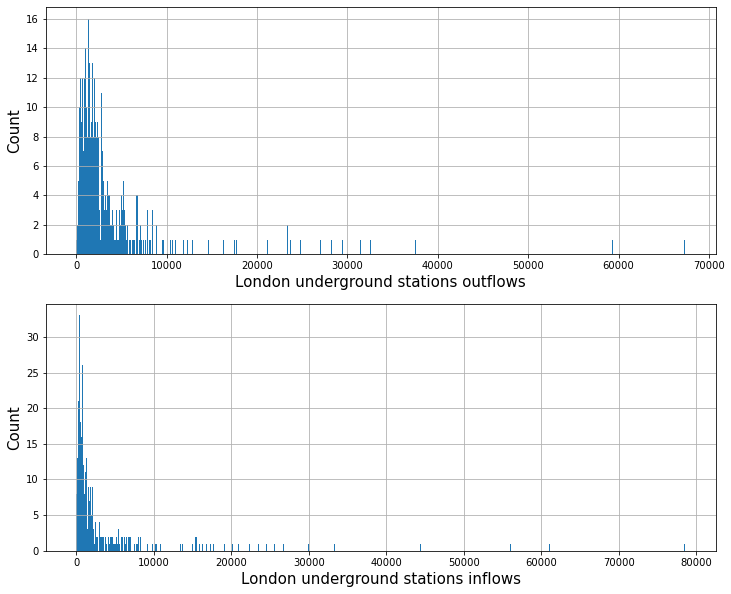

In [324]:
#let's plot this as a histogram
bin_size=100
fig, ax = plt.subplots(2,1,figsize=(12,10))
ax[0].hist(outflows, bins=int(outflows.max()[0]/bin_size))
ax[0].set_xlabel('London underground stations outflows', fontsize = 15)
ax[0].set_ylabel("Count", fontsize= 15)
ax[0].grid(True)

ax[1].hist(inflows, bins=int(inflows.max()[0]/bin_size))
ax[1].set_xlabel('London underground stations inflows', fontsize = 15)
ax[1].set_ylabel("Count", fontsize= 15)
ax[1].grid(True)
plt.show()

In [390]:
cdatasub.head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,unconstrainedEst,...,alpha_i,jobs_new,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,change_A,doubsimfitted2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,45.840497,...,-4.035699,78549.0,293.0,16575.659926,0.000016,156.0,0.000017,171.0,171.0,125.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,0.592568,...,-4.035699,442.0,4.0,223.556023,0.000016,2.0,0.000017,2.0,1.0,3.0


In [407]:
#### flows after changing jobs
outflows1 =cdatasub.groupby('station_origin').sum()
outflows1 = outflows1[['prodsimest4']]
outflows1.sort_values('prodsimest4').head(10)

,prodsimest4
station_origin,
Battersea Park,0.0
West India Quay,164.0
Cheshunt,173.0
Hyde Park Corner,236.0
Bushey,239.0
South Hampstead,249.0
Shenfield,250.0
Beckton Park,295.0
Cambridge Heath,325.0


In [408]:
outflows1.sort_values('prodsimest4').tail(10)

,prodsimest4
station_origin,
Highbury & Islington,23711.0
Finsbury Park,24732.0
Canada Water,27029.0
King's Cross St. Pancras,28307.0
Bank and Monument,29500.0
Liverpool Street,31472.0
London Bridge,32600.0
Victoria,37511.0
Stratford,59313.0


In [404]:
####  flows after changing jobs
inflows1 =cdatasub.groupby('station_destination').sum()
inflows1 = inflows1[['prodsimest4']]
inflows1.sort_values('prodsimest4').head(10)

,prodsimest4
station_destination,
Battersea Park,0.0
Emerson Park,4.0
Hatch End,44.0
Cheshunt,46.0
South Hampstead,47.0
Kilburn High Road,56.0
Beckton Park,65.0
Theobalds Grove,73.0
Roding Valley,86.0


In [405]:
inflows1.sort_values('prodsimest4').tail(10)

,prodsimest4
station_destination,
London Bridge,24555.0
Canada Water,25232.0
Victoria,26778.0
King's Cross St. Pancras,26942.0
Highbury & Islington,31354.0
Canary Wharf,32966.0
Oxford Circus,34828.0
Liverpool Street,67347.0
Bank and Monument,72836.0


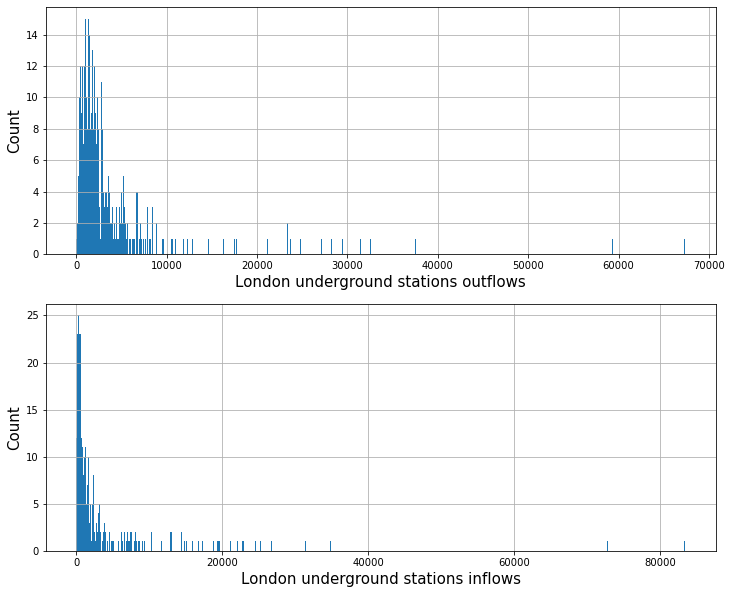

In [409]:
#let's plot this as a histogram
bin_size=100
fig, ax = plt.subplots(2,1,figsize=(12,10))
ax[0].hist(outflows1, bins=int(outflows1.max()[0]/bin_size))
ax[0].set_xlabel('London underground stations outflows', fontsize = 15)
ax[0].set_ylabel("Count", fontsize= 15)
ax[0].grid(True)

ax[1].hist(inflows1, bins=int(inflows1.max()[0]/bin_size))
ax[1].set_xlabel('London underground stations inflows', fontsize = 15)
ax[1].set_ylabel("Count", fontsize= 15)
ax[1].grid(True)
plt.show()

### Shapefile data 

In [410]:
stations = gpd.read_file('data/tfl_stations.json')
lines = gpd.read_file('data/tfl_lines.json')

In [411]:
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

<AxesSubplot:>

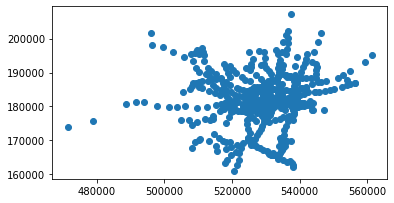

In [412]:
stations.plot()

In [413]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

In [414]:
import re
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

In [415]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

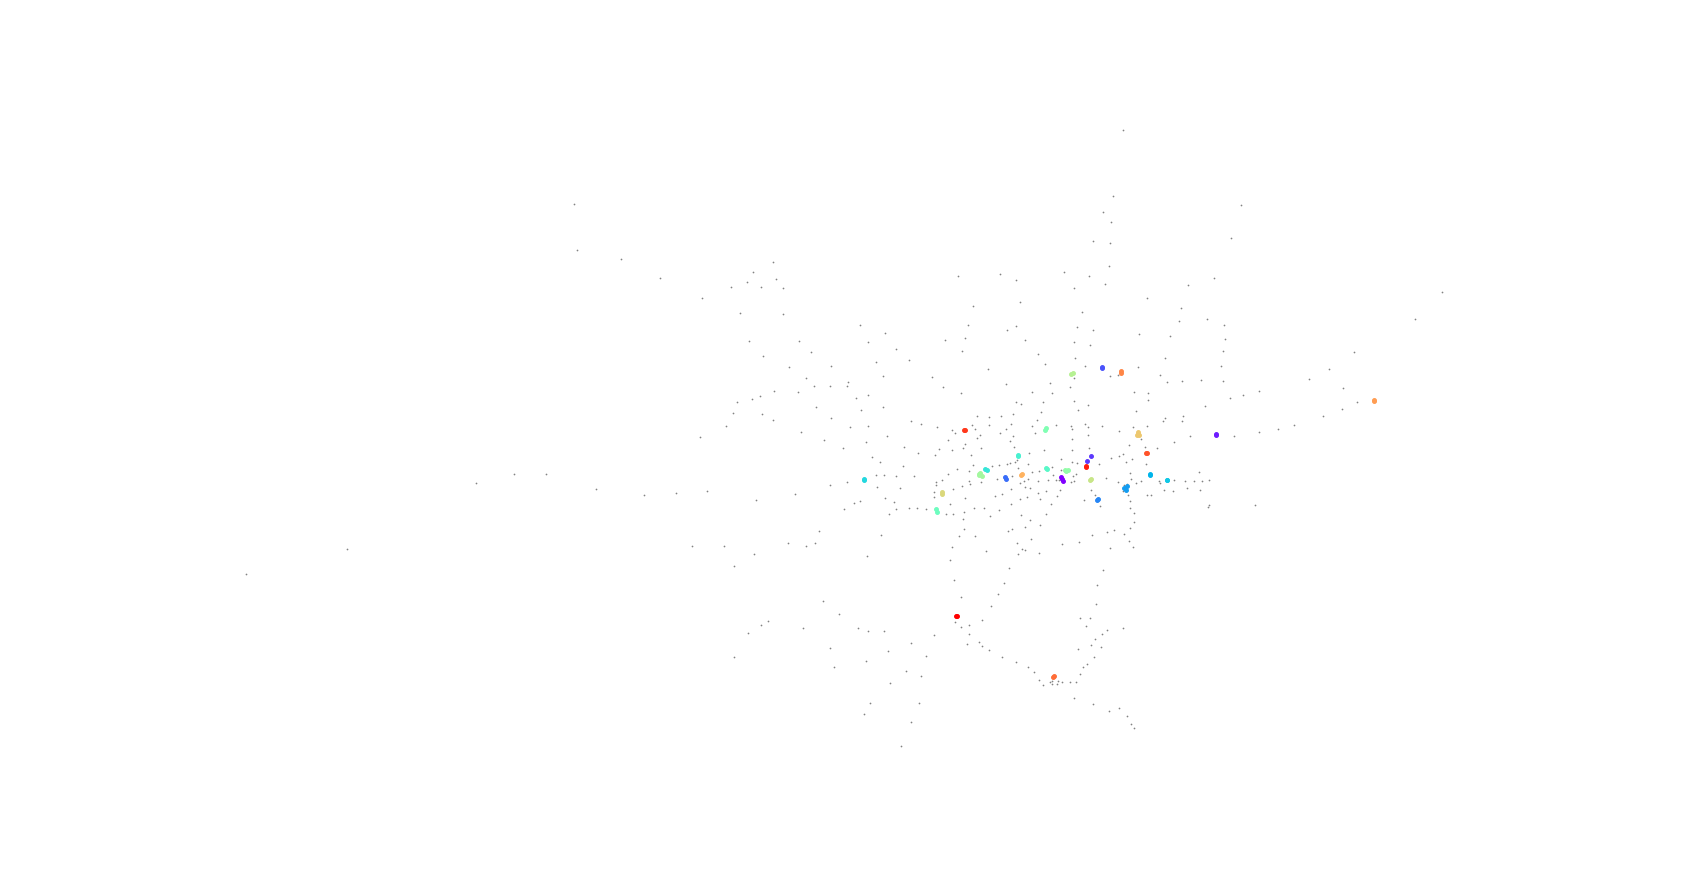

In [416]:
## we will plot all the stations with multiple points to check there are no errors
fig, ax = plt.subplots(figsize = (30,30))
# ax.set_aspect("equal")
ax.axis('off')
ax.margins(0.2)
color = iter(cm.rainbow(np.linspace(0, 1, 29)))
stations.plot(ax=ax, color='grey', markersize=0.5)
for i, group in stations.groupby('name'):
    if len(group)>1:
        group.plot(ax=ax, color = next(color), markersize=15)
plt.show()

In [445]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [418]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

<AxesSubplot:>

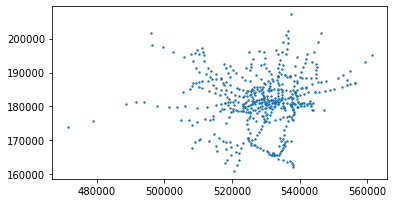

In [419]:
#check plot to make sure there are no errors
stations.plot(markersize=2)

In [420]:
lines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        701 non-null    object  
 1   lines     701 non-null    object  
 2   geometry  701 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 16.6+ KB


In [421]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

['Piccadilly',
 'London Overground',
 'District',
 'DLR',
 'Victoria',
 'Waterloo & City',
 'Northern',
 'Metropolitan',
 'Thameslink 6tph line',
 'Circle',
 'Hammersmith & City',
 'Bakerloo',
 'Crossrail 2',
 'Emirates Air Line',
 'TfL Rail',
 'Tramlink',
 'Jubilee',
 'Crossrail',
 'Central',
 'East London']

In [422]:
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

In [423]:
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

Piccadilly


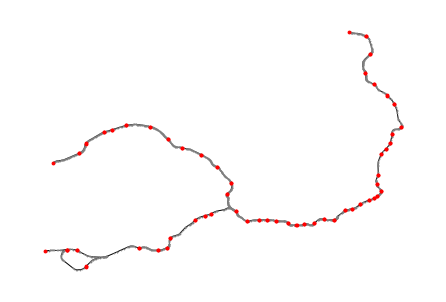

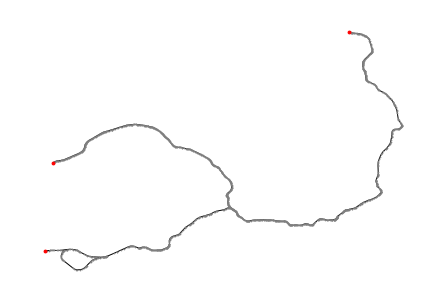

1
London Overground


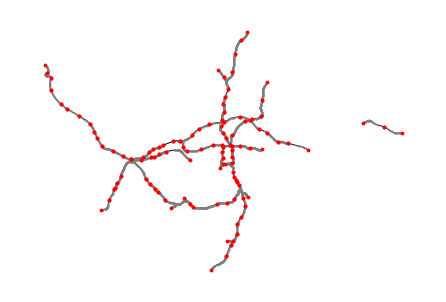

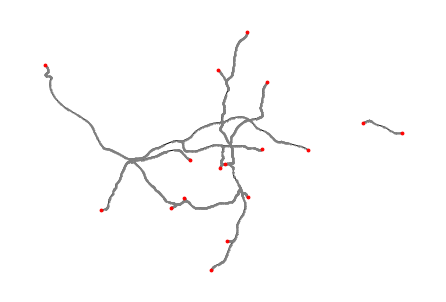

3
District


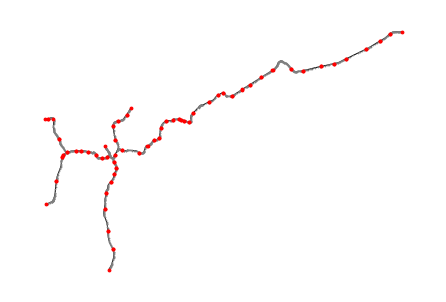

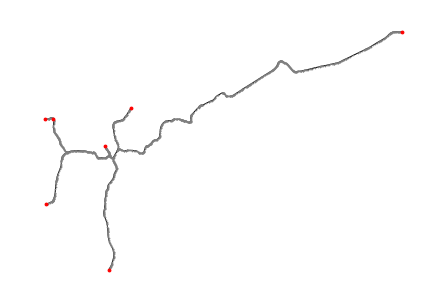

1
DLR


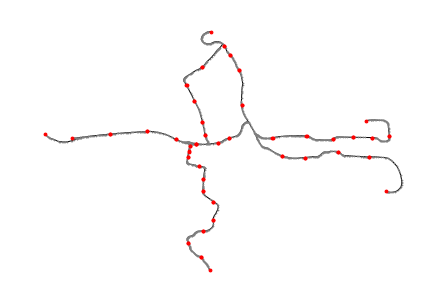

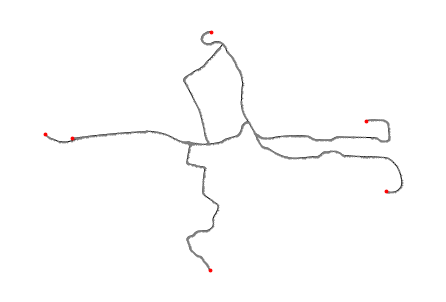

1
Victoria


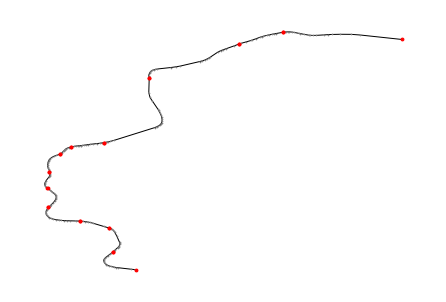

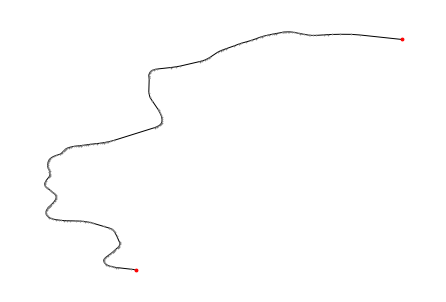

1
Waterloo & City


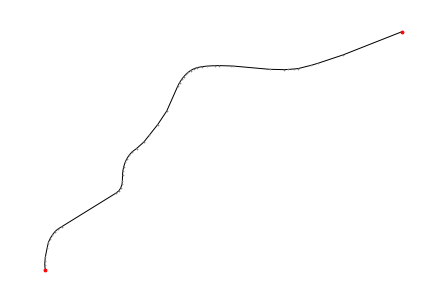

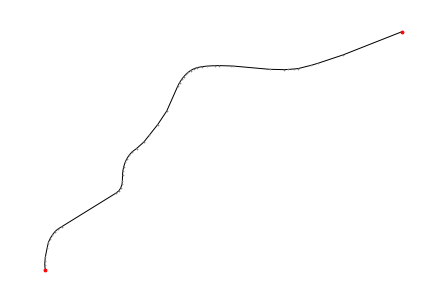

1
Northern


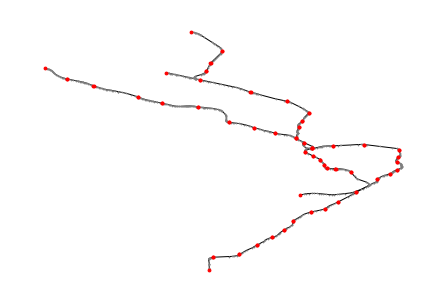

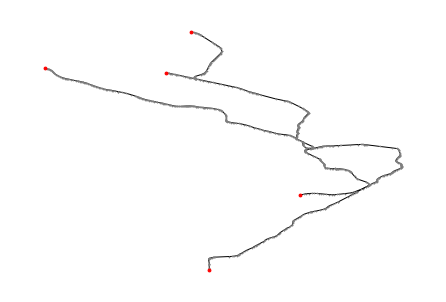

1
Metropolitan


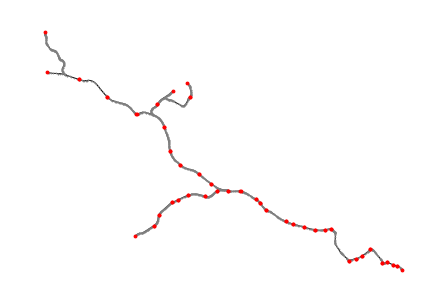

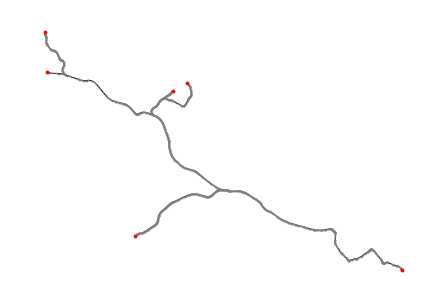

1
Circle


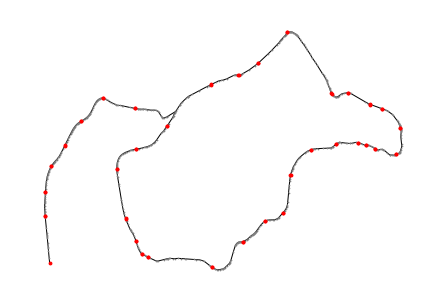

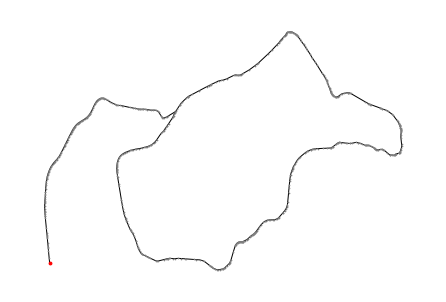

1
Hammersmith & City


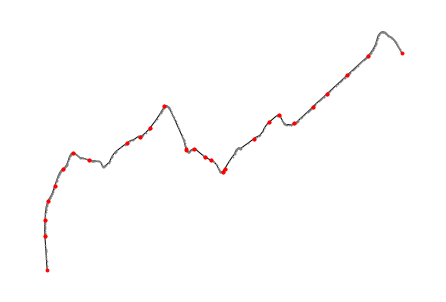

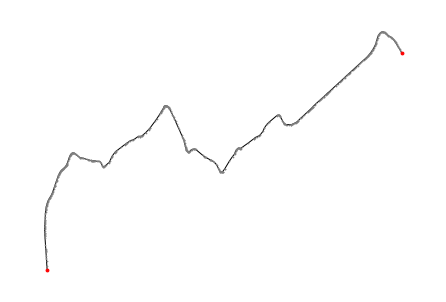

1
Bakerloo


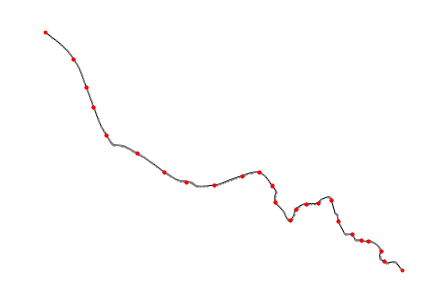

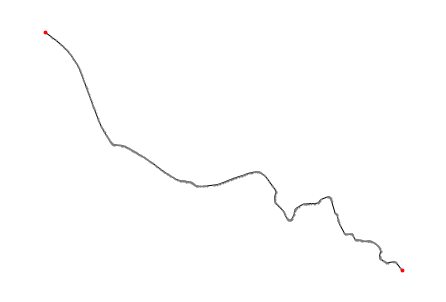

1
TfL Rail


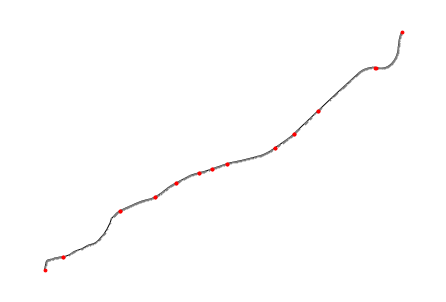

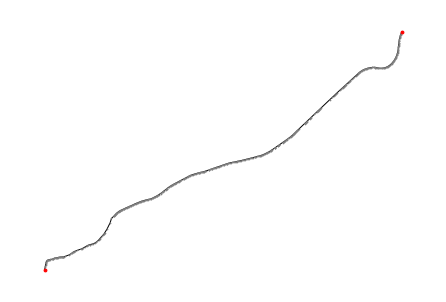

1
Jubilee


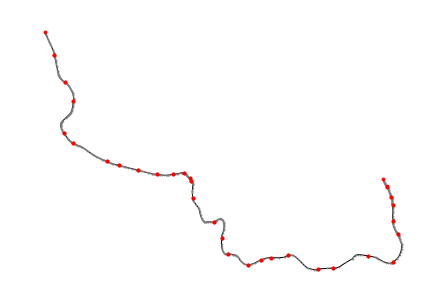

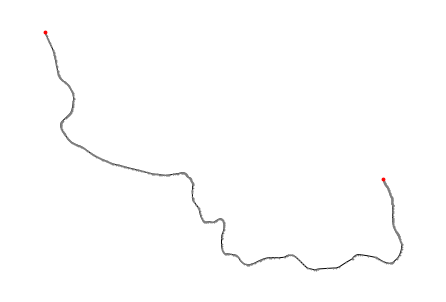

1
Central


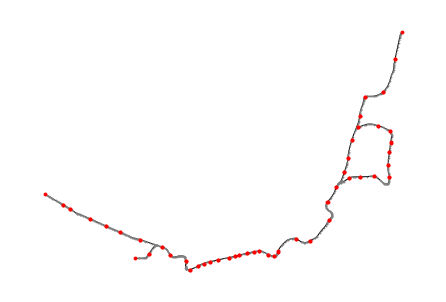

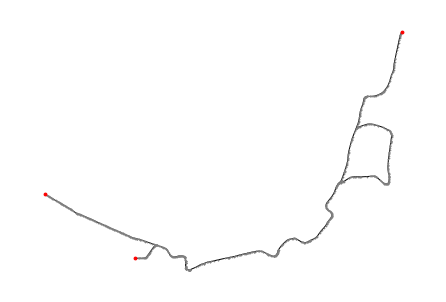

1


In [424]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


In [425]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

,line_name,start_id,end_id,geometry
0,Piccadilly,940GZZLUECT,940GZZLUGTR,"LINESTRING (525466.770 178494.187, 526201.148 ..."
1,Piccadilly,940GZZLUECT,940GZZLUBSC,"LINESTRING (525466.770 178494.187, 524110.791 ..."
2,Piccadilly,940GZZLUECT,940GZZLUBSC,"LINESTRING (525466.770 178494.187, 524110.791 ..."
3,Piccadilly,940GZZLUBSC,940GZZLUHSD,"LINESTRING (524110.791 178324.969, 523377.084 ..."
4,Piccadilly,940GZZLUHSD,940GZZLUTNG,"LINESTRING (523377.084 178624.185, 521266.715 ..."


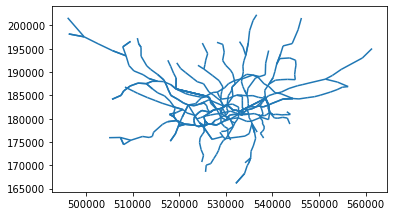

In [426]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

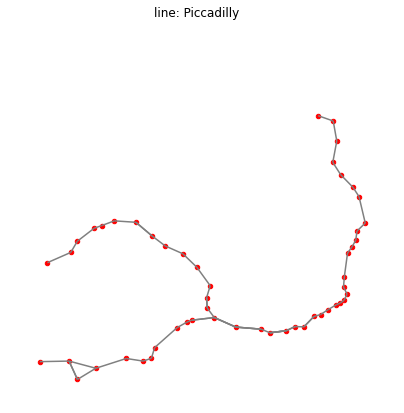

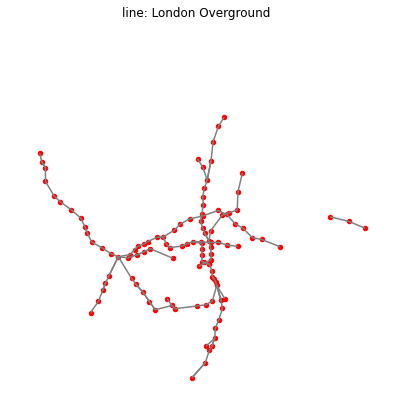

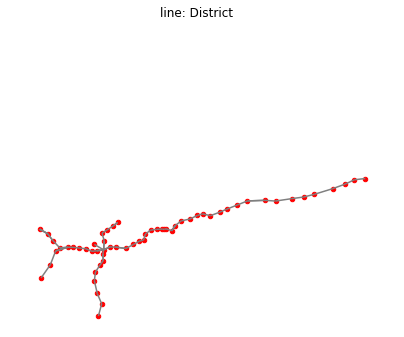

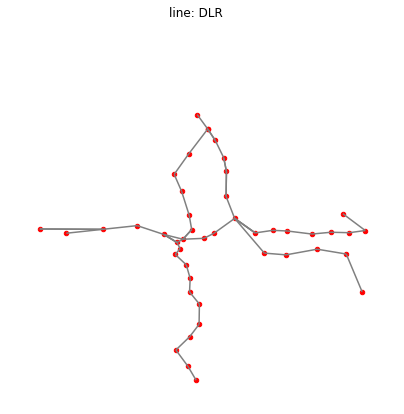

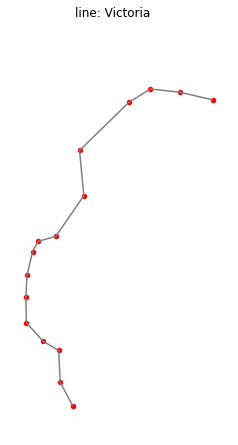

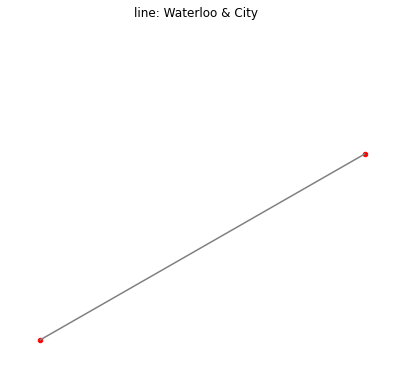

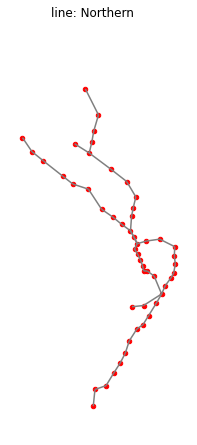

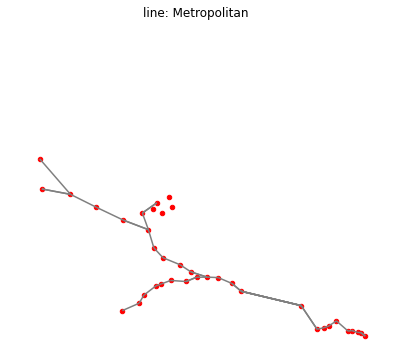

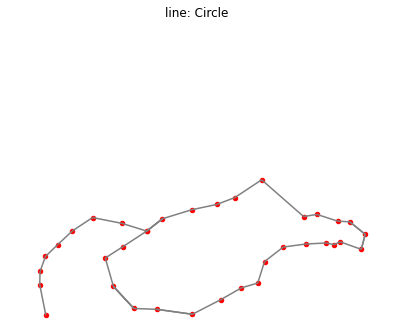

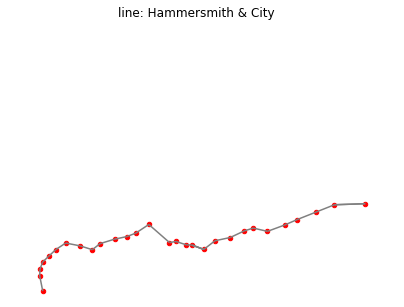

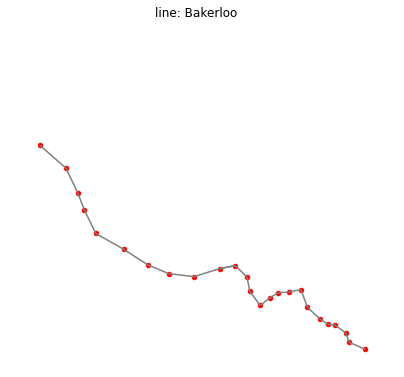

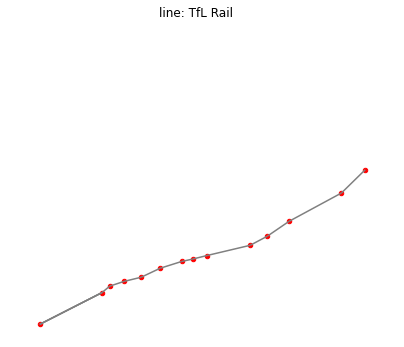

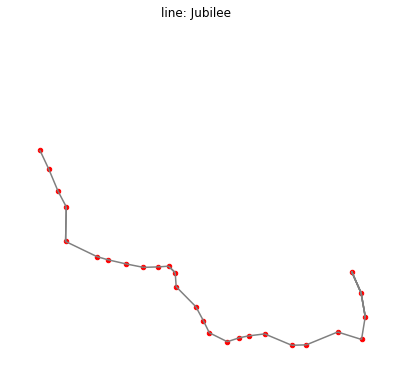

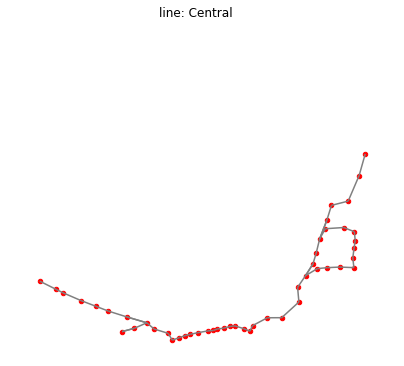

In [427]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

<AxesSubplot:>

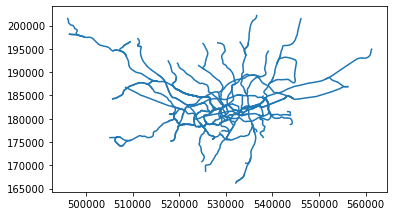

In [428]:
#plot to sanity check
edge_gdf.plot()

In [429]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [430]:
#let's replace the ids with the actual nane
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [431]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

In [432]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

In [433]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

In [434]:
#if want to know what is the maximum distance between stations
max(dict(G.edges).items(), key=lambda x: x[1]['length'])

(('Wembley Park', 'Finchley Road'),
 {'length': 7266.373927496304, 'line_name': 'Metropolitan'})

In [435]:
#check that our OD data and network data match
OD_names = set(cdatasub.station_origin.unique())
network_names = set([n for n in G.nodes()])

In [436]:
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Battersea Power Station', 'Nine Elms']

In [437]:
cdatasub1 = cdatasub[~cdatasub.station_origin.isin(_filter)]
cdatasub1 = cdatasub[~cdatasub.station_destination.isin(_filter)]

In [579]:
##### !!! add flow data
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}
A = {(u,v): 0 for u,v in G.edges()}
T = {(u,v): 0 for u,v in G.edges()}
H = {(u,v): 0 for u,v in G.edges()}

In [615]:
#calculate shortest paths for all flows and add data to dict
for i, row in cdatasub.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            H[(u,v)] += row.change_H
        except:
            H[(v,u)] += row.change_H

In [621]:
#calculate shortest paths for all flows and add data to dict
for i, row in cdatasub.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            A[(u,v)] += row.change_A
        except:
            A[(v,u)] += row.change_A

In [616]:
#calculate shortest paths for all flows and add data to dict
for i, row in cdatasub.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            T[(u,v)] += row.change_T
        except:
            T[(v,u)] += row.change_T

In [259]:
CalcRSqaured(cdatasub["flows"], cdatasub["prodsimest4"])

0.3670164613295204

In [258]:
CalcRMSE(cdatasub["flows"], cdatasub["prodsimest4"])

104.958

In [622]:
nx.set_edge_attributes(G, T, 'change_T')

In [623]:
nx.set_edge_attributes(G, H, 'change_H')

In [624]:
nx.set_edge_attributes(G, A, 'change_A')

In [625]:
#check and you can find the change_A is already in your network!
max(dict(G.edges).items(), key=lambda x: x[1]['length'])

(('Wembley Park', 'Finchley Road'),
 {'length': 7266.373927496304,
  'line_name': 'Metropolitan',
  'flows': 42081.0,
  'change_A': 41890.0,
  'change_T': 87928.0,
  'change_H': 38902.0})

In [635]:
change.sort_values(by='change_A')

,station_origin,station_destination,change_A,change_T,change_H
55949,Waterloo,Bank and Monument,-13164.0,-15498.0,-12949.0
55974,Waterloo,Canary Wharf,-6813.0,-4378.0,-5207.0
32654,London Bridge,Canary Wharf,-5554.0,-5618.0,-4906.0
50095,Stratford,Liverpool Street,-5152.0,-6692.0,-5687.0
54825,Victoria,Oxford Circus,-4221.0,-5073.0,-4131.0
...,...,...,...,...,...
56175,Waterloo,Victoria,1069.0,-126.0,1168.0
49911,Stratford,Bank and Monument,1081.0,-222.0,1098.0
54669,Victoria,Bank and Monument,1102.0,835.0,1498.0
11664,Clapham Junction,Stratford,1214.0,768.0,737.0


In [592]:
change.sort_values(by='change_T').head(10)

,station_origin,station_destination,change_A,change_T,change_H
55949,Waterloo,Bank and Monument,-13164.0,-15498.0,-12949.0
50095,Stratford,Liverpool Street,-5152.0,-6692.0,-5687.0
32654,London Bridge,Canary Wharf,-5554.0,-5618.0,-4906.0
54825,Victoria,Oxford Circus,-4221.0,-5073.0,-4131.0
55974,Waterloo,Canary Wharf,-6813.0,-4378.0,-5207.0
8542,Canada Water,Canary Wharf,-3569.0,-4020.0,-3401.0
49948,Stratford,Canary Wharf,-2906.0,-3798.0,-2517.0
32403,Liverpool Street,Farringdon,-3258.0,-3746.0,-3332.0
18965,Finsbury Park,Highbury & Islington,-3274.0,-3657.0,-3440.0
8662,Canada Water,London Bridge,-2732.0,-3162.0,-2743.0


In [593]:
change.sort_values(by='change_H').head(10)

,station_origin,station_destination,change_A,change_T,change_H
55949,Waterloo,Bank and Monument,-13164.0,-15498.0,-12949.0
50095,Stratford,Liverpool Street,-5152.0,-6692.0,-5687.0
55974,Waterloo,Canary Wharf,-6813.0,-4378.0,-5207.0
32654,London Bridge,Canary Wharf,-5554.0,-5618.0,-4906.0
54825,Victoria,Oxford Circus,-4221.0,-5073.0,-4131.0
18965,Finsbury Park,Highbury & Islington,-3274.0,-3657.0,-3440.0
8542,Canada Water,Canary Wharf,-3569.0,-4020.0,-3401.0
32403,Liverpool Street,Farringdon,-3258.0,-3746.0,-3332.0
8662,Canada Water,London Bridge,-2732.0,-3162.0,-2743.0
49948,Stratford,Canary Wharf,-2906.0,-3798.0,-2517.0


In [626]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

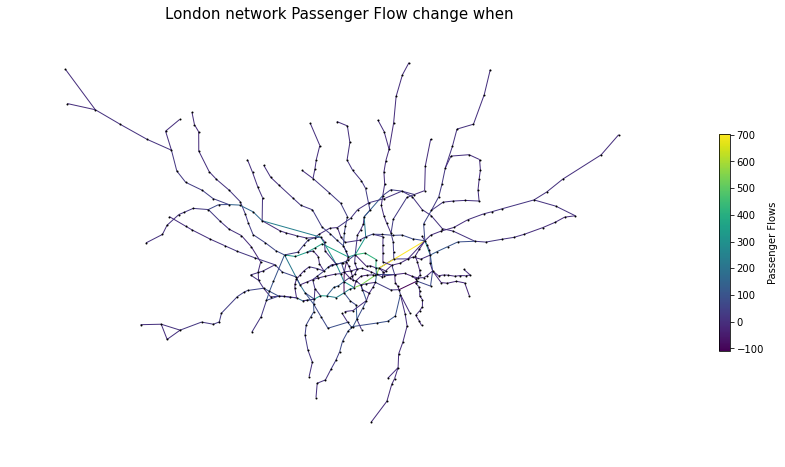

In [627]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['change_A']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(15,8))
#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=1)
nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flow change when ",fontsize=15)
plt.show()

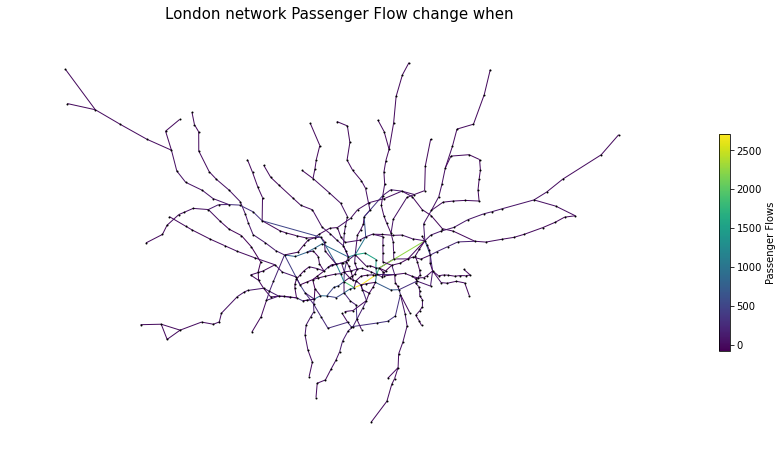

In [628]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['change_T']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(15,8))
#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=1)
nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flow change when ",fontsize=15)
plt.show()

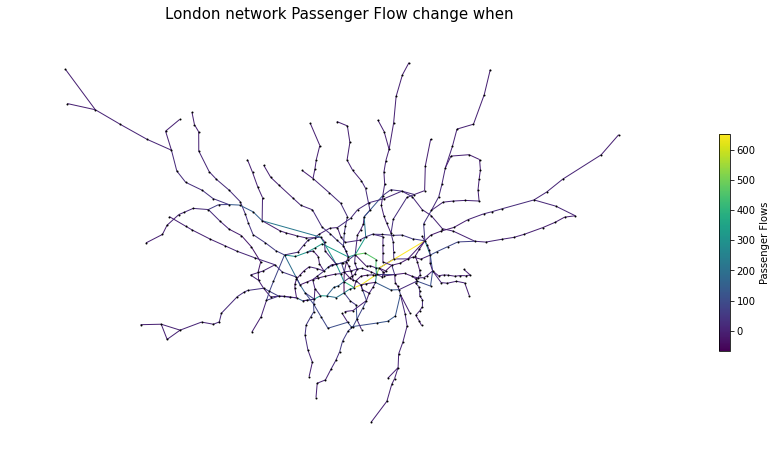

In [629]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['change_H']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(15,8))
#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=1)
nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flow change when ",fontsize=15)
plt.show()